### OCR Demo

In [1]:
import os
import cv2

from glob import glob
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted

from BDRC.data import OpStatus
from BDRC.exporter import JsonExporter, PageXMLExporter, TextExporter
from BDRC.inference import OCRPipeline

from BDRC.utils import show_image, create_dir, get_filename, read_line_model_config, read_layout_model_config, read_ocr_model_config, save_ocr_lines_parquet

In [2]:
data_path = "Data/W22273-v2"
output_dir = os.path.join(data_path, "Output")
create_dir(output_dir)

xml_exporter = PageXMLExporter(output_dir)
json_exporter = JsonExporter(output_dir)
text_exporter = TextExporter(output_dir)

img_ext = "jpg"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

print(f"Images: {len(image_paths)}")

Images: 870


(560, 3173, 3)
Data/W22273-v2\I1KG22370006.jpg
I1KG22370006


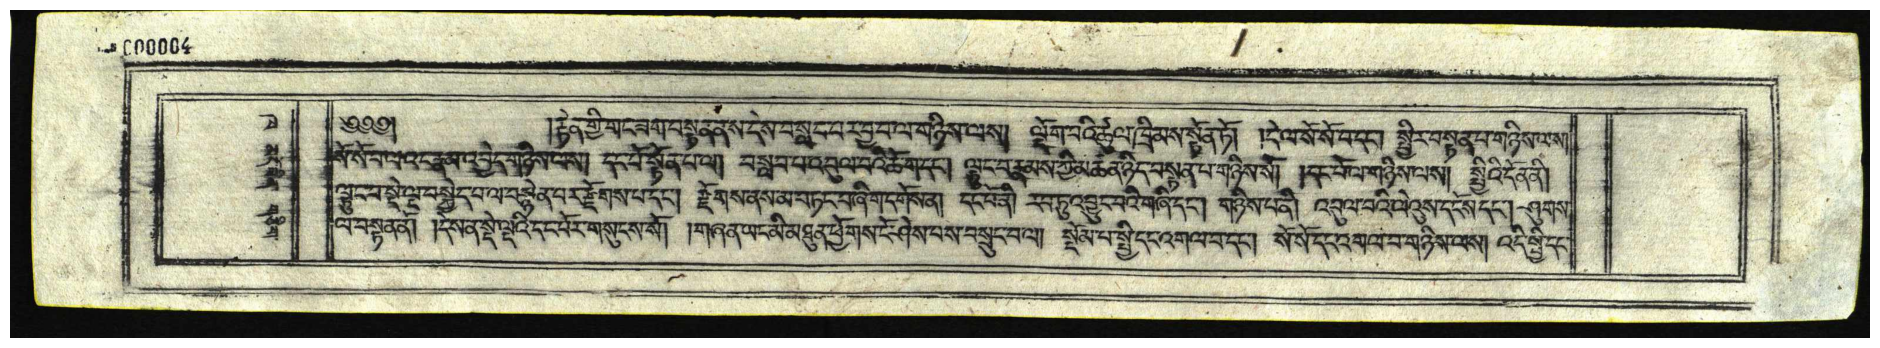

In [3]:
idx = 3
img = cv2.imread(image_paths[idx], cv2.IMREAD_COLOR_RGB)
print(img.shape)
print(image_paths[idx])
image_name = get_filename(image_paths[idx])
print(image_name)
show_image(img)

#### OCR via Pipelines using a line or layout model

In [4]:
# run download_al_models.py to download models and configs from HuggingFace
line_model_config_file = "Models/BDRC/PhotiLines/config.json"
layout_model_config_file = "Models/BDRC/Photi-v2/config.json"

line_model_config = read_line_model_config(line_model_config_file)
layout_model_config = read_layout_model_config(layout_model_config_file)
#modern_layout_model_config = read_layout_model_config(modern_layout_config_file)

In [5]:
# OCR pipeline with woodblock mdoel and layout model
ocr_model_config_file = "Models/BDRC/Woodblock/model_config.json"
#ocr_model_config_file = "Models/BDRC/BigUCHAN_v1/config.json"
ocr_model_config = read_ocr_model_config(ocr_model_config_file)
ocr_pipeline = OCRPipeline(ocr_model_config, line_model_config, False)

Available ONNX providers: ['AzureExecutionProvider', 'CPUExecutionProvider']
Available ONNX providers: ['AzureExecutionProvider', 'CPUExecutionProvider']


In [ ]:
status, result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5, eval_mode=True)
rot_mask, sorted_lines, ocr_lines, page_angle = result

In [ ]:
# debug ocr_lines
ocr_lines

[OCRLine(guid=UUID('1fec8dbf-ed41-11f0-8017-f8e4e3e82870'), text='ཏཏ', encoding='UNICODE', ctc_conf=0.47616900155892744, logits=[-5.193877097307624, -5.204342238226619, -5.2052769041275955, -5.215742045046591, -5.285991488761195, -5.296456629680191, -5.300961749703218, -5.311426890622213, -6.224521990953864, -6.235921797773836], lm_scores=None),
 OCRLine(guid=UUID('1febc9ce-ed41-11f0-8017-f8e4e3e82870'), text='བབྱ།རྟེན་གྱི་གང་ཟག་བསུ་རྣམས་དེས་བསླུབ་པར་བ་བ་ལ་གཉེས་ལས།ལྡོག་པའི་ཐེལ་ཁྲིམས་སྟོན་ཏོ༎དེ་ལ་སོ་སོ་བ་དང་།སྲེར་བསྣན་པ་གཉིས་ལས༎', encoding='UNICODE', ctc_conf=0.8781816067823847, logits=[-33.38477938157715, -33.39715769419643, -33.50351872932449, -33.50713853818573, -33.51589704194378, -33.51951685080501, -33.64746563417114, -33.659843946790424, -33.74529757084191, -33.7576758834612], lm_scores=None),
 OCRLine(guid=UUID('1febc9cd-ed41-11f0-8017-f8e4e3e82870'), text='སོ་སོ་བ་ལའང་རྣམ་འབྱེད་གཉིས་ལས།དང་པོ་སྟོན་པ་ལ།བསླུབ་པ་འབུལ་བའི་ཆོ་ག་དང་།ལྟུང་བ་རྣམས་ཀྱི་མཚན་ཉིད་བསྟན་པ་གཉིས་སོ༎དང་པོ་ལ་གཉིས་

In [10]:
# save parquet
parq_out = f"Data/{image_name}.parquet"
save_ocr_lines_parquet(ocr_lines, parq_out)

#### Single Volume

In [ ]:
# single volume
data_path = "Data/W22273-v2"
output_dir = os.path.join(data_path, "Output")
create_dir(output_dir)

text_exporter = TextExporter(output_dir)
xml_exporter = PageXMLExporter(output_dir)

img_ext = "png"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

if len(image_paths) > 0:
    for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        image_name = get_filename(image_path)

        page_name = os.path.basename(image_path)
        base = os.path.splitext(page_name)[0]
        img = cv2.imread(image_path)
        status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5, eval_mode=True)
        
        if status == OpStatus.SUCCESS:
            _, lines, ocr_lines, angle = ocr_result
            if len(ocr_lines) > 0:
                xml_exporter.export_lines(img, base, lines, ocr_lines, angle=angle)
                text_exporter.export_lines(img, base, lines, ocr_lines)

                parq_out = f"{output_dir}/{image_name}.parquet"
                save_ocr_lines_parquet(ocr_lines, parq_out)

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


#### Run Multiple Volumes

In [ ]:
# run on all data
ocr_model_config_file = "Models/BDRC/BigUCHAN_v1/config.json"
ocr_model_config = read_ocr_model_config(ocr_model_config_file)

work_id = "W22081_all"
root_dir = "C:/Users/Eric/Downloads/W22081_all"

output_dir = os.path.join(root_dir, "Output")
create_dir(output_dir)

ocr_pipeline = OCRPipeline(ocr_model_config, line_model_config, False)

for sub_dir in Path(root_dir).iterdir():
    if sub_dir.name == "Output":
        continue
    
    if f"{work_id}" in str(sub_dir) and os.path.isdir(sub_dir):

        volume_out = os.path.join(output_dir, str(sub_dir.name))

        if os.path.exists(volume_out):
            continue

        create_dir(volume_out)
        print(volume_out)
        text_exporter = TextExporter(volume_out)
        xml_exporter = PageXMLExporter(volume_out)

        img_ext = "tif"
        image_paths = natsorted(glob(f"{sub_dir}/*.{img_ext}"))
        print(f"{sub_dir.name} => Images: {len(image_paths)}")

        if len(image_paths) > 0:
            for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
                page_name = os.path.basename(image_path)
                base = os.path.splitext(page_name)[0]
                img = cv2.imread(image_path)
                status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5)

                if status == OpStatus.SUCCESS:
                    _, lines, ocr_lines, angle = ocr_result
                    if len(ocr_result[2]) > 0:
                        xml_exporter.export_lines(img, base, lines, ocr_lines, angle=angle)
                        text_exporter.export_lines(img, base, lines, ocr_lines)